<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Topic Modeling with Latent Dirichlet Allocation (LDA)

In [1]:
#importing libaries
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [2]:
data = pd.read_pickle("data.pkl")
data.head()

,Review,Rating,Sentiment,cleaned_reviews
0,"unique, great stay, wonderful time hotel monac...",5,1.0,unique great stay wonderful time hotel monaco ...
1,"great stay great stay, went seahawk game aweso...",5,1.0,great stay great stay go seahawk game awesome ...
2,love monaco staff husband stayed hotel crazy w...,5,1.0,love monaco staff husband stay hotel crazy wee...
3,"cozy stay rainy city, husband spent 7 nights m...",5,1.0,cozy stay rainy city husband spend night monac...
4,"hotel stayed hotel monaco cruise, rooms genero...",5,1.0,hotel stay hotel monaco cruise room generous d...


In [3]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = data.cleaned_reviews.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['unique', 'great', 'stay', 'wonderful', 'time', 'hotel', 'monaco', 'location', 'excellent', 'short', 'stroll', 'main', 'downtown', 'shopping', 'area', 'pet', 'friendly', 'room', 'show', 'sign', 'animal', 'hair', 'smell', 'monaco', 'suite', 'sleep', 'area', 'big', 'striped', 'curtain', 'pull', 'closed', 'nice', 'touch', 'feel', 'cosy', 'goldfish', 'name', 'brandi', 'enjoyed', 'partake', 'free', 'wine', 'coffee', 'tea', 'service', 'lobby', 'think', 'great', 'feature', 'great', 'staff', 'friendly', 'free', 'wireless', 'internet', 'hotel', 'work', 'suite', 'laptop', 'decor', 'lovely', 'eclectic', 'mix', 'patten', 'color', 'palatte', 'animal', 'print', 'bathrobe', 'feel', 'like', 'rock', 'star', 'nice', 'look', 'like', 'sterile', 'chain', 'hotel', 'hotel', 'personality', 'excellent', 'stay']]


In [4]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    #texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [5]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.039*"food" + 0.028*"pool" + 0.020*"drink" + 0.020*"people" + '
  '0.017*"resort" + 0.017*"restaurant" + 0.016*"bar" + 0.016*"beautiful" + '
  '0.015*"eat" + 0.014*"time"'),
 (1,
  '0.048*"room" + 0.024*"hotel" + 0.016*"night" + 0.015*"stay" + 0.014*"time" '
  '+ 0.011*"check" + 0.011*"day" + 0.011*"service" + 0.010*"little" + '
  '0.009*"book"'),
 (2,
  '0.027*"water" + 0.023*"bad" + 0.020*"tell" + 0.014*"towel" + 0.014*"give" + '
  '0.012*"bring" + 0.008*"theft" + 0.008*"call" + 0.008*"month" + '
  '0.008*"charge"'),
 (3,
  '0.076*"hotel" + 0.047*"great" + 0.039*"stay" + 0.037*"room" + 0.025*"staff" '
  '+ 0.020*"location" + 0.018*"breakfast" + 0.015*"friendly" + 0.013*"clean" + '
  '0.013*"walk"')]


In [6]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.5302,"hotel, great, stay, room, staff, location, bre...","[unique, great, stay, wonderful, time, excelle..."
1,1,1,0.4075,"room, hotel, night, stay, time, check, day, se...","[great, stay, great, stay, seahawk, game, awes..."
2,2,0,0.3447,"food, pool, drink, people, resort, restaurant,...","[husband, stay, hotel, crazy, weekend, attend,..."
3,3,3,0.5505,"hotel, great, stay, room, staff, location, bre...","[stay, husband, spend, night, early, business,..."
4,4,1,0.6230,"room, hotel, night, stay, time, check, day, se...","[hotel, cruise, room, generous, decorate, uniq..."


In [7]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.8414,"food, pool, drink, people, resort, restaurant, bar, beautiful, eat, time","[resort, relax, crowd, time, food, great, variaty, reciews, read, people, food, guess, expect, p..."
1,1,0.9637,"room, hotel, night, stay, time, check, day, service, little, book","[watch, stay, hotel, enjoy, hit, hotel, week, review, equally, positive, wanted, drop, review, r..."
2,2,0.7248,"water, bad, tell, towel, give, bring, theft, call, month, charge","[live, mold, mildew, tiny, bed, metal, sink, cool, extra, instead, nightsta]"
3,3,0.9698,"hotel, great, stay, room, staff, location, breakfast, friendly, clean, walk","[fantastic, fantastic, hotel, fantastic, set, fantastic, city, love, argonaut, homely, quirky, r..."


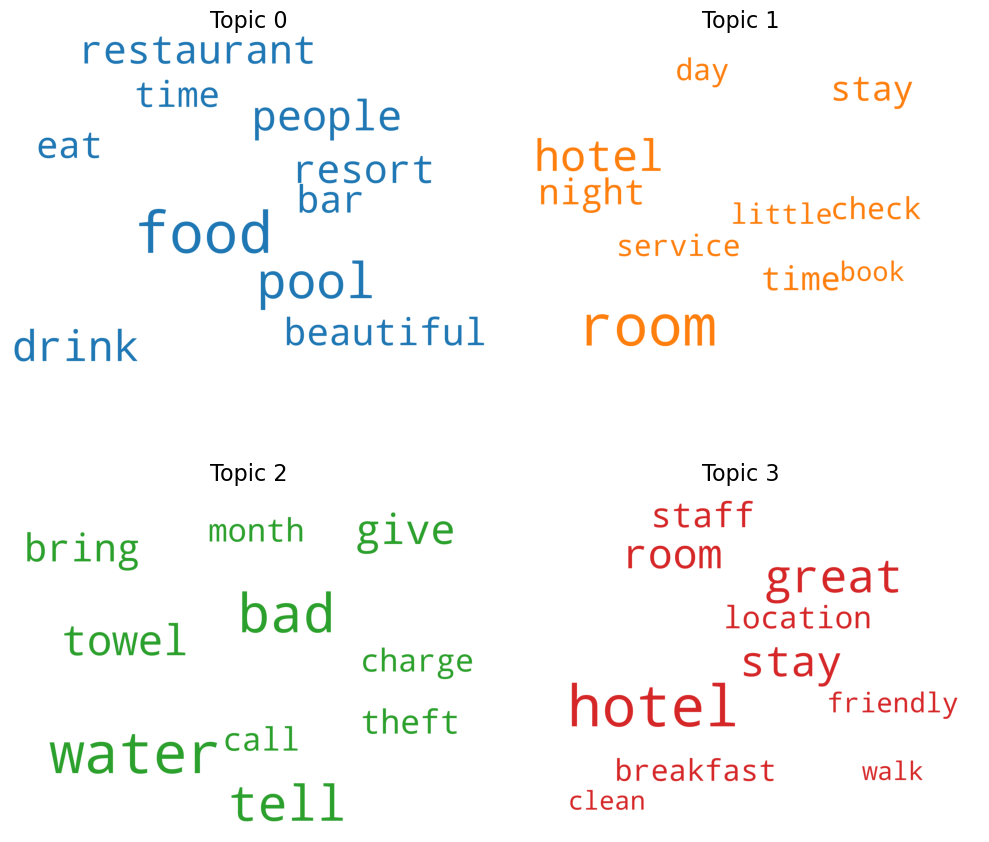

In [8]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

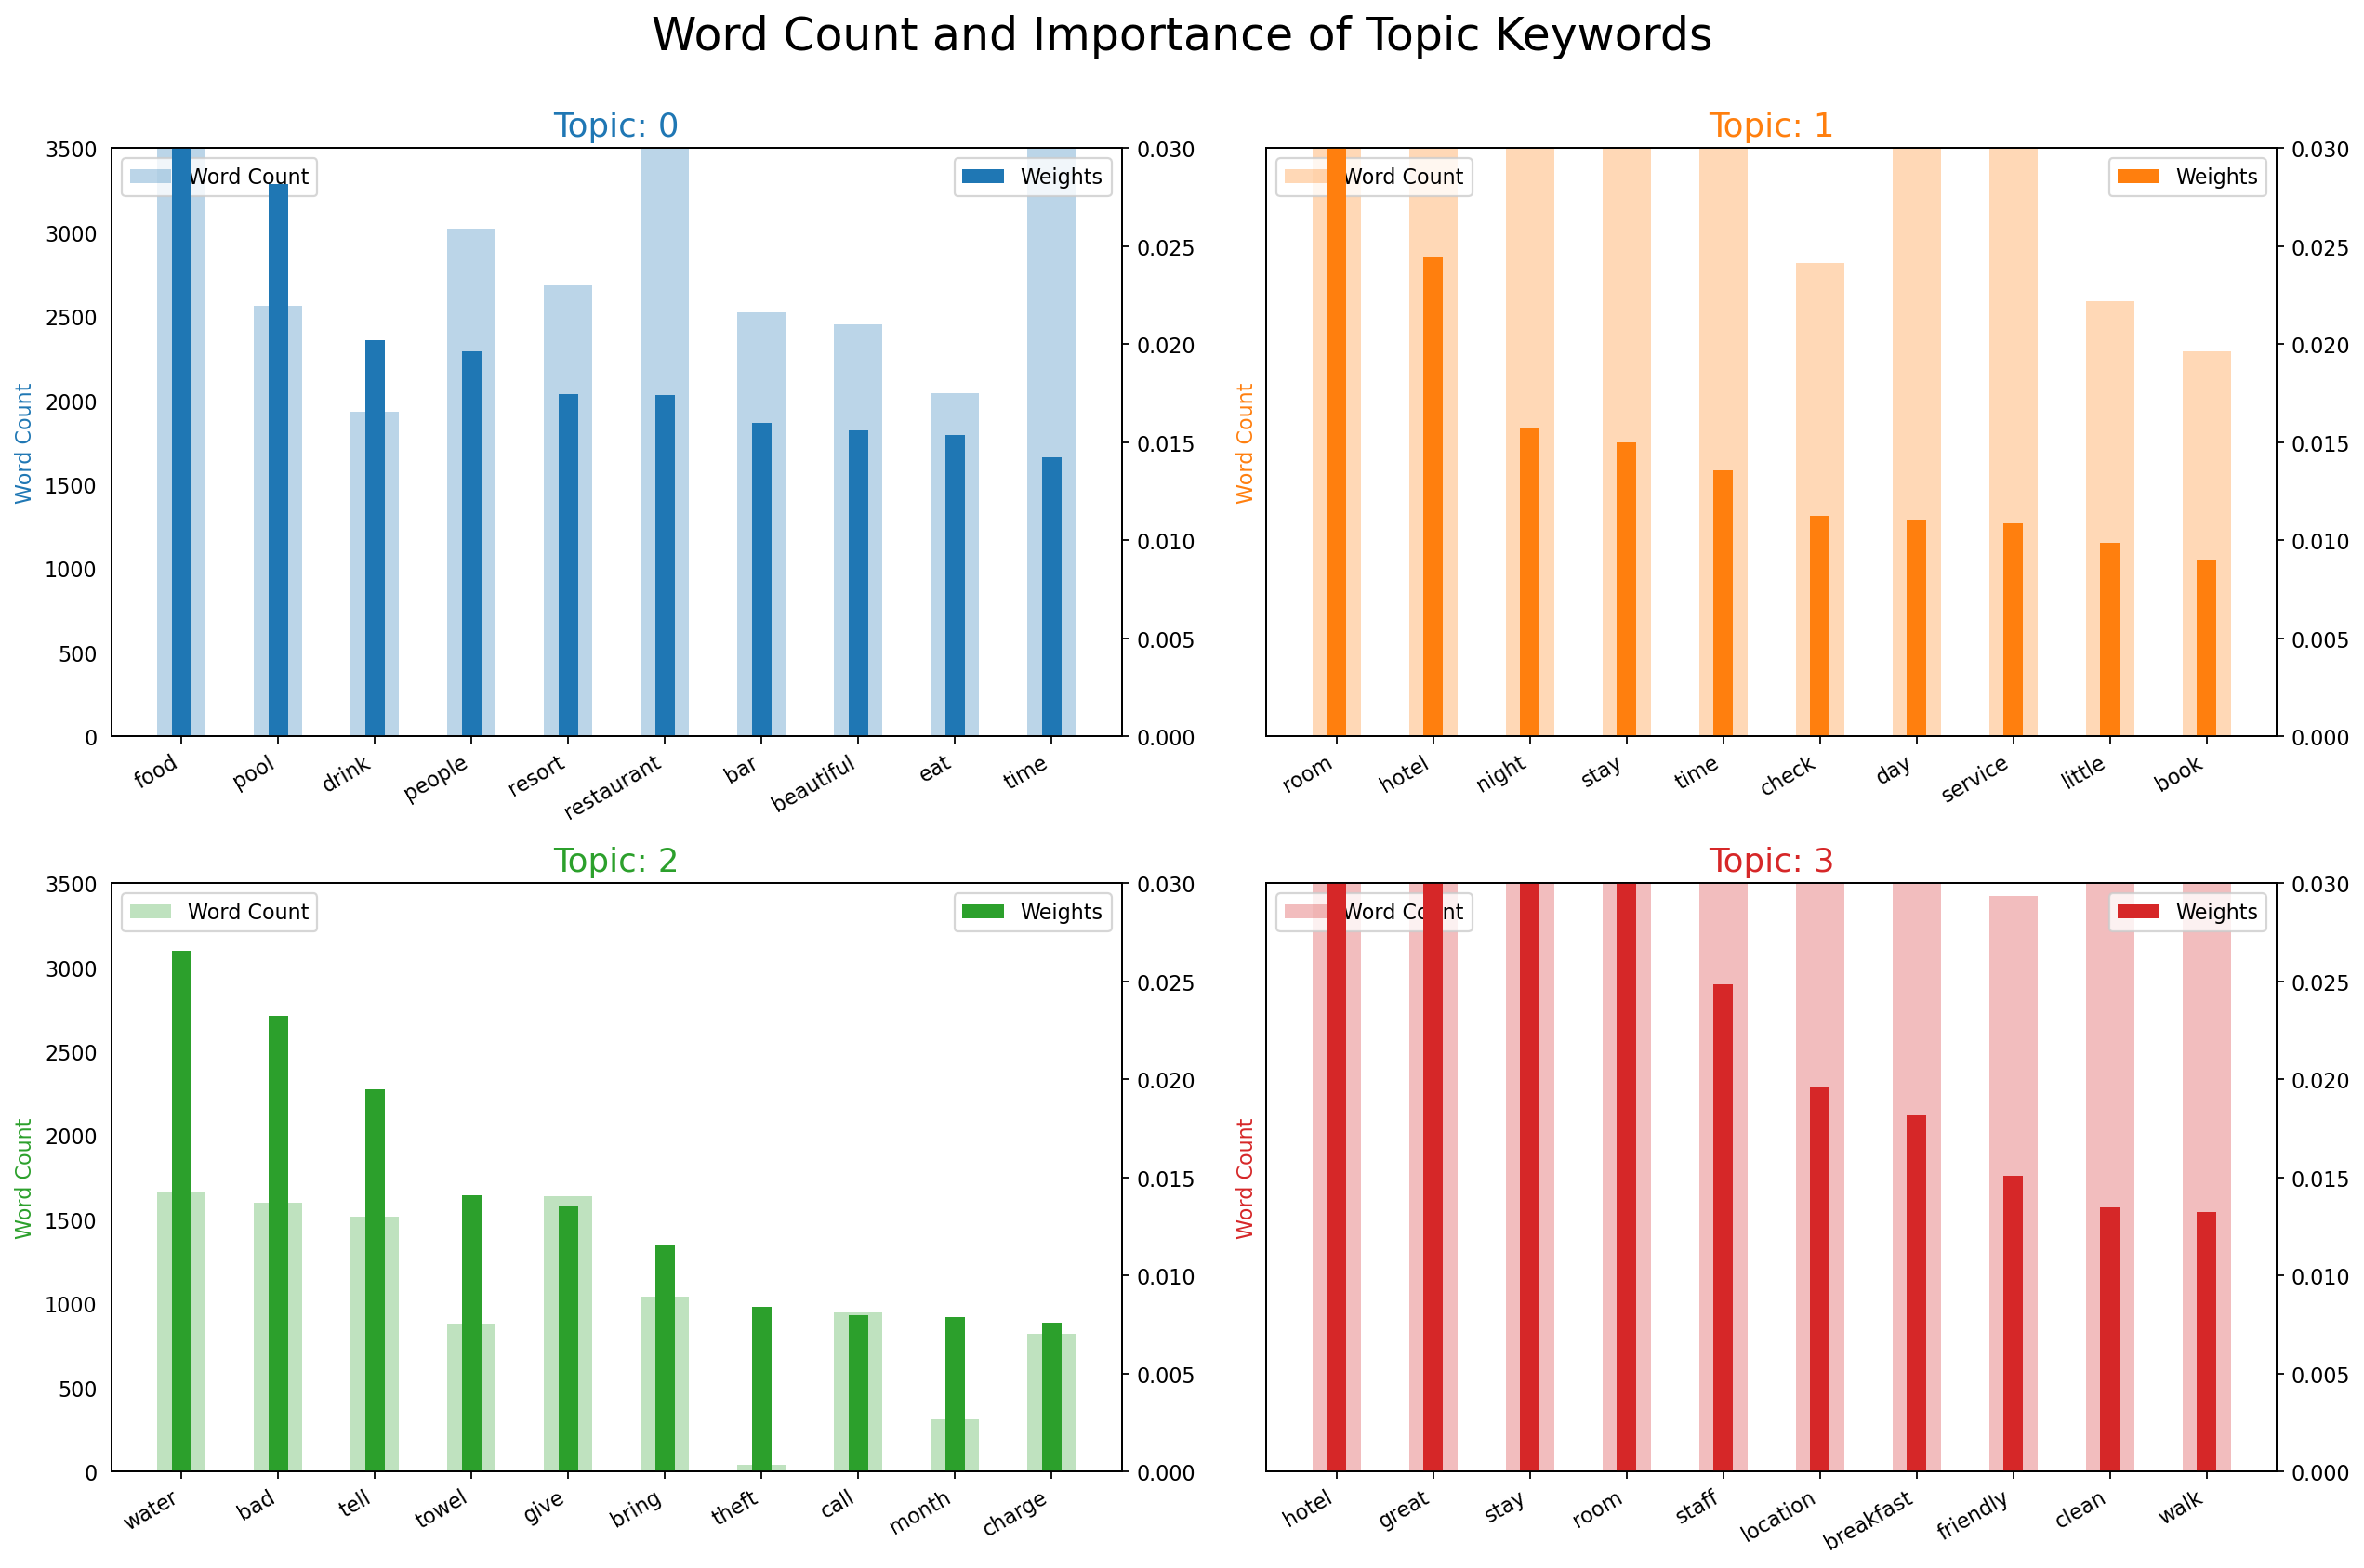

In [9]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [10]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

ModuleNotFoundError: No module named 'pyLDAvis'